In [1]:
pip install PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Timestamp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import BlackLittermanModel, CovarianceShrinkage

from tensorflow.keras import Sequential
from keras.layers import Dense, GRU, Dropout
from tensorflow.keras.layers import LeakyReLU

import warnings
warnings.filterwarnings('ignore')

**데이터셋 생성 : 1.BL구성용 2.모델학습용**

In [4]:
## BL 포트폴리오 데이터셋 생성
# 데이터 병합
sectors_price_data = {}
excel_file_path1 = 'stocks_1999_2020_data_by_sector.xlsx'
price_data = pd.ExcelFile(excel_file_path1)
for sheet_name in price_data.sheet_names:
    sheet_data1 = pd.read_excel(excel_file_path1, sheet_name=sheet_name)
    sheet_data1['Date'] = pd.to_datetime(sheet_data1['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data1.set_index('Date', inplace=True)
    sheet_data1.drop(columns='Unnamed: 0', inplace=True)
    sectors_price_data[sheet_name] = sheet_data1

# 데이터프레임 생성
price_df = pd.DataFrame()
for sector, data in sectors_price_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if price_df.empty:
        price_df = data
    else:
        price_df = price_df.join(data, how='outer')

# 로그수익률 생성
logReturn_df = np.log(price_df / price_df.shift(1))
logReturn_df = logReturn_df.dropna()

모델 학습데이터 구성해야하는데, 일단 학습데이터를 구성해서 학습시키고, 테스트 데이터를 만들어서 뷰를 구성해야하는 테스트 데이터만드는 코드도 추가해야함.


In [5]:
def generate_model_data(start_of_learn, test_start_date, invest_data):
    model_learning_data_X = []
    model_learning_data_y = []
    start_day_idx = [] # data_X를 생성하기 위한 매달 시작일 인덱스 리스트
    model_start_date = start_of_learn - pd.DateOffset(years=2) - pd.DateOffset(months=9)
    model_end_date = start_of_learn - pd.DateOffset(days=1)

    while model_start_date < model_end_date:
        end_of_model = model_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        selected_data = logReturn_df[(logReturn_df.index >= model_start_date) & (logReturn_df.index <= end_of_model)]
        indexing = logReturn_df.index.get_loc(selected_data.index[0])

        # 각 주식에 대한 월별 평균 수익률 계산
        average_values = selected_data.mean(axis=0)

        model_learning_data_y.append(average_values)
        start_day_idx.append(indexing)
        model_start_date = model_start_date + pd.DateOffset(months=1)  # Move to next month

    i = 0
    while i < len(model_learning_data_y):
        index_day_start = start_day_idx[i]

        nearest_index = None
        for j in range(index_day_start, index_day_start - 60, -1):
            if j < 0:
                break
            if logReturn_df.index[j] in logReturn_df.index:
                nearest_index = j
                break

        if nearest_index is not None:
            sixty_day_data = logReturn_df.iloc[nearest_index - 60 : nearest_index]
            model_learning_data_X.append(sixty_day_data)
        else:
            pass

        i += 1
    idx = logReturn_df.index.get_loc(invest_data.index[0])
    model_testing_data_X = logReturn_df.iloc[idx-61:idx-1]
    model_testing_data_X = np.array(model_testing_data_X)

    return model_learning_data_X, model_learning_data_y, model_testing_data_X

def scale_data(model_learning_data_X, model_learning_data_y, model_testing_data_X):
    # 전체 데이터 중 최소값과 최대값 구하기
    tot_train_min = np.minimum.reduce([np.min(model_learning_data_X), np.min(model_learning_data_y)])
    tot_train_max = np.maximum.reduce([np.max(model_learning_data_X), np.max(model_learning_data_y)])

    # 각 주식의 범위를 계산
    train_range = tot_train_max - tot_train_min

    # 스케일링
    L_scale_model_data_X = (model_learning_data_X - tot_train_min) / (train_range + 1e-7)
    L_scale_model_data_y = (model_learning_data_y - tot_train_min) / (train_range + 1e-7)
    T_scale_model_data_X = (model_testing_data_X - tot_train_min) / (train_range + 1e-7)

    T_scale_model_data_X = np.reshape(T_scale_model_data_X, (-1, 60, 55))

    return L_scale_model_data_X, L_scale_model_data_y, T_scale_model_data_X, train_range, tot_train_min


def GRU_model(L_scale_model_data_X, L_scale_model_data_y, T_scale_model_data_X, train_range, tot_train_min):
    """
    create a GRU model trained on X_train and y_train
    and make predictions on the X_test data
    """
    # create a model
    # The GRU architecture
    GRU_model = Sequential()
    GRU_model.add(GRU(units = 50, return_sequences = True, input_shape = (60, 55)))
    GRU_model.add(LeakyReLU())
    GRU_model.add(GRU(units = 50))
    GRU_model.add(LeakyReLU())
    GRU_model.add(Dropout(0.2))
    GRU_model.add(Dense(units = 55))

    # Compiling the RNN
    GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    print('훈련 데이터의 크기 :', L_scale_model_data_X.shape, L_scale_model_data_y.shape)
    print('테스트 데이터의 크기 :', T_scale_model_data_X.shape)

    # Fitting to the trainig set
    GRU_model.fit(L_scale_model_data_X, L_scale_model_data_y, epochs=400, batch_size=128, verbose=0)

    # Predicting on test sets
    predictions = GRU_model.predict(T_scale_model_data_X)
    # Un-scailing
    _predictions = predictions * (train_range + 1e-7) + tot_train_min

    __predictions = binarize_predictions(_predictions)
    return __predictions

def binarize_predictions(predictions):
    # 로그 수익률이 0보다 크면 상승(1), 그렇지 않으면 하락(0)으로 판단
    binary_predictions = np.where(predictions > 0, 1, -1)
    return binary_predictions

2002-04-01 00:00:00 1 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 753ms/step
2002-05-01 00:00:00 2 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 726ms/step
except
2002-06-01 00:00:00 3 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 716ms/step
2002-07-01 00:00:00 4 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 714ms/step
except
2002-08-01 00:00:00 5 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)


1/1 [==============================] - 1s 756ms/step
2002-09-01 00:00:00 6 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)


1/1 [==============================] - 1s 735ms/step
except
2002-10-01 00:00:00 7 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 730ms/step
except
2002-11-01 00:00:00 8 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 707ms/step
except
2002-12-01 00:00:00 9 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 723ms/step
except
2003-01-01 00:00:00 10 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 713ms/step
except
2003-02-01 00:00:00 11 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 758ms/step
except
2003-03-01 00:00:00 12 번째 학습
훈련 데이터의 크기 : (33, 60, 55) (33, 55)
테스트 데이터의 크기 : (1, 60, 55)
1/1 [==============================] - 1s 729ms/step
except
2003-04-01 00:00:00 13 번째 학습
훈련 데이터의 크기 : (

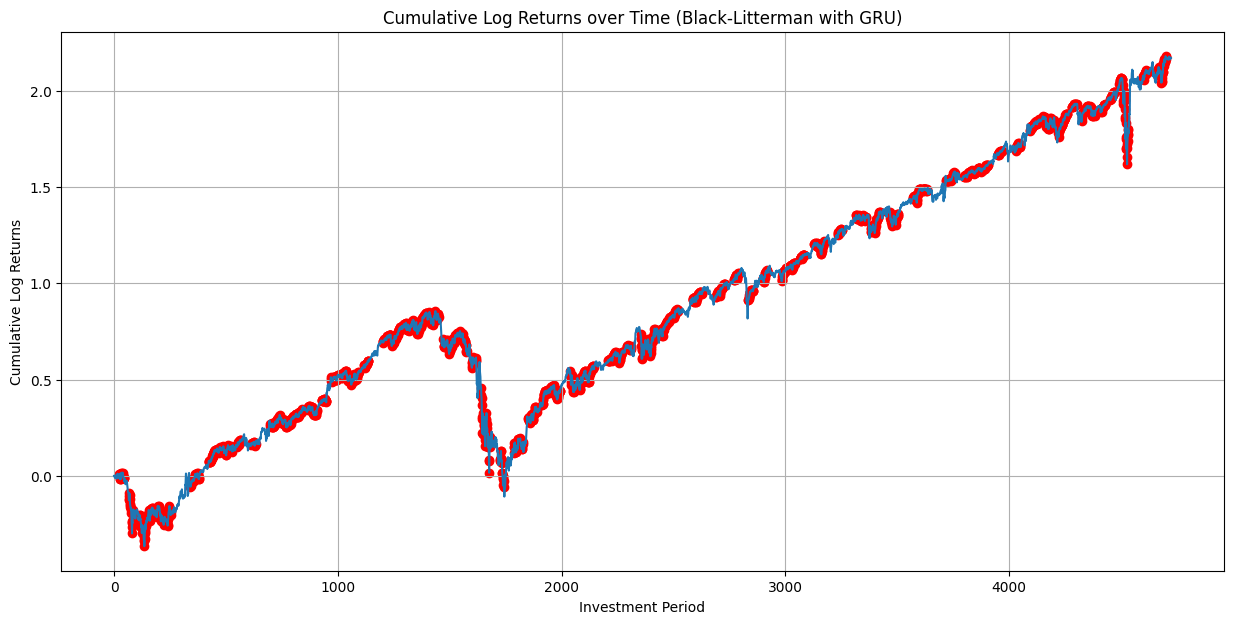

In [6]:
# 날짜 계산
test_start_date = pd.Timestamp('2002-04-01')
test_end_date = pd.Timestamp('2020-12-31')

# 누적 수익률 초기화
cumulative_returns = [0]

learn_data = []
invest_data = []
exception_indices = []
exception_values = []
exception_count = 0
i = 1


# 포트폴리오 최적화(블랙-리터만)과 리밸런싱
while test_start_date < test_end_date:
    exception_occurred = False  # 예외 발생 여부를 추적하기 위한 플래그
    monthly_indices = []  # 이번 달의 인덱스를 저장할 리스트

    print(test_start_date, i, '번째 학습')
    start_of_learn = test_start_date - pd.DateOffset(months=3)
    end_of_invest = test_start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # BL PF 데이터셋 구성
    learn_data = price_df[(price_df.index >= start_of_learn) & (price_df.index < test_start_date)]
    invest_data = price_df[(price_df.index >= test_start_date) & (price_df.index <= end_of_invest)]
    invest_log_return = logReturn_df[(logReturn_df.index >= test_start_date) & (logReturn_df.index <= end_of_invest)]

    model_learning_data_X = []
    model_learning_data_y = []
    model_testing_data_X  = []
    L_scale_model_data_X  = []
    L_scale_model_data_y = []
    T_scale_model_data_X = []
    # 예측 모델 학습 Step1.테스트 학습데이터셋과 테스트데이터 생성
    model_learning_data_X, model_learning_data_y, model_testing_data_X = generate_model_data(start_of_learn, test_start_date, invest_data)
    # 예측 모델 학습 Step2.데이터 스케일링하기
    L_scale_model_data_X, L_scale_model_data_y, T_scale_model_data_X, train_range, tot_train_min = scale_data(model_learning_data_X, model_learning_data_y, model_testing_data_X)
    # 예측 모델 학습 Step3.예측 돌리기
    Q = GRU_model(L_scale_model_data_X, L_scale_model_data_y, T_scale_model_data_X, train_range, tot_train_min)

    # 수익률 예측값으로 P, Q 행렬 구성
    Q = np.array(Q).reshape(-1, 1)
    P = np.zeros((55, len(learn_data.columns)))

    for k in range(55):
      P[k,k] = 1

    # Omega 행렬
    omega = np.eye(55) * 0.01

    # 블랙리터만 뷰 설정 및 최적화
    S = CovarianceShrinkage(learn_data).ledoit_wolf()
    bl = BlackLittermanModel(S, P=P, Q=Q, omega=omega)
    ret_bl = bl.bl_returns()
    ef = EfficientFrontier(ret_bl, S)
    try:
      weights = ef.max_sharpe()
    except:
      print('except')
      weights = {}
      exception_occurred = True  # 예외 발생 플래그 설정
      exception_count += 1  # 예외 발생 횟수 증가
      for j in learn_data.columns:
        weights[j] = 1/55 # 1/n 씩 투자했다고 가정

    # 일별수익률
    portfolio_log_return = (invest_log_return * pd.Series(weights)).sum(axis=1)
    new_cumulative_return = 0  # 누적 로그 수익률 초기화

    # 이 달에 대한 누적 수익률을 계산
    for daily_return in portfolio_log_return.tolist():
        new_cumulative_return = cumulative_returns[-1] + daily_return
        cumulative_returns.append(new_cumulative_return)
        if exception_occurred:
            monthly_indices.append(len(cumulative_returns) - 1)


    # # 월별수익률
    # portfolio_log_return = (invest_log_return * pd.Series(weights)).sum(axis=1)
    # cumulative_log_return = portfolio_log_return.sum()
    # # 누적 로그 수익률 업데이트
    # cumulative_returns.append(cumulative_returns[-1] + cumulative_log_return)

    # 예외가 발생했다면 이 달의 인덱스를 exception_indices에 추가
    if exception_occurred:
        exception_indices.extend(monthly_indices)
        exception_values.extend([cumulative_returns[idx] for idx in monthly_indices])

    # 다음 투자 기간으로 이동
    test_start_date = test_start_date + pd.DateOffset(months=1)
    i += 1

plt.figure(figsize=(15, 7))
plt.plot(cumulative_returns, label='Cumulative Log Returns')

# 예외가 발생한 인덱스에 대해 다른 색상으로 점 표시
plt.scatter(exception_indices, exception_values, color='r', marker='o', label='Exceptions')

plt.grid(True)
plt.xlabel('Investment Period')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns over Time (Black-Litterman with GRU)')
plt.show()

print(exception_count, "/", i-1)

In [ ]:
df = pd.DataFrame(cumulative_returns)
df.to_excel('cumulative_returns.xlsx')

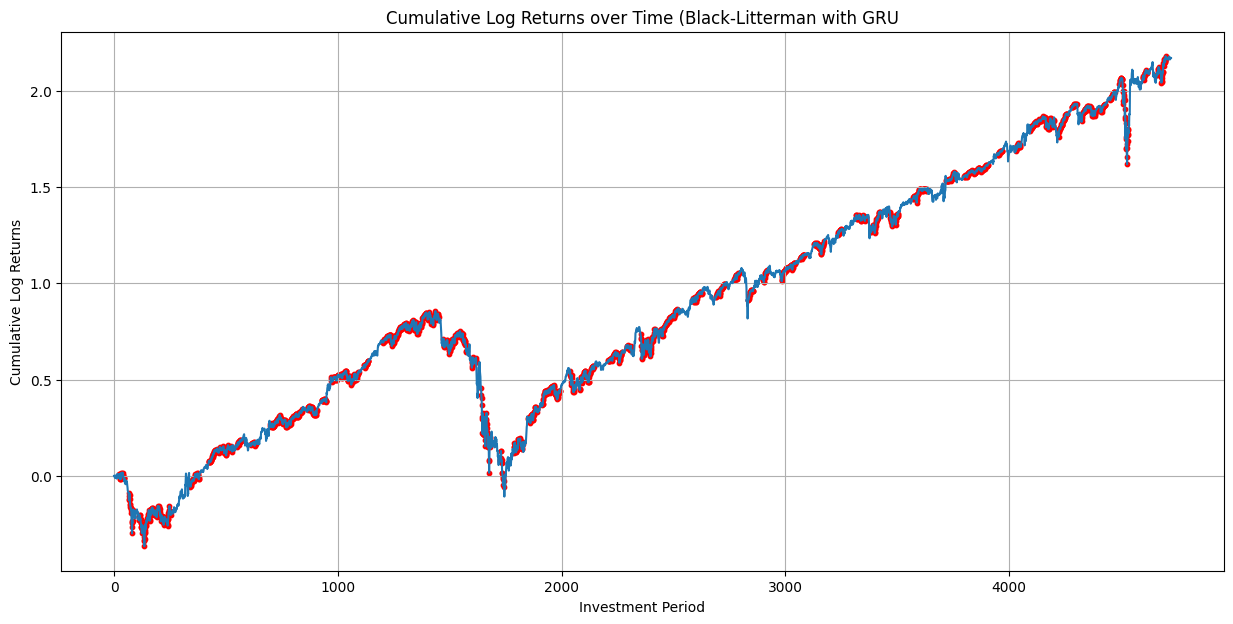

In [14]:
plt.figure(figsize=(15,7))
plt.plot(cumulative_returns, label='Cumulative Log Returns')

# 예외가 발생한 인덱스에 대해 다른 색상으로 점 표시
plt.scatter(exception_indices, exception_values, color='r', marker='o', s=10, label='Exceptions')

plt.grid(True)
plt.xlabel('Investment Period')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns over Time (Black-Litterman with GRU')
plt.show()

In [15]:
cumulative_returns[-1]

2.1701467007487154

In [7]:
print(exception_count, "/", i-1)

129 / 225
